In [4]:
%pip install kagglehub
%pip install pandas
%pip install -U jupyter ipywidgets
%pip install -U jupyterlab-widgets
%pip install seaborn
%pip install scikit-learn
%pip install gensim
%pip install numpy==1.26.4

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings("ignore")

file_path = "arxiv.csv"  # File in locale poiché convertito localmente da JSON a csv

# Carica il file CSV in un DataFrame
df = pd.read_csv(file_path)

# Stampa il numero di righe e mostra le prime righe
print(f"Numero di righe nel dataset: {df.shape[0]}")
df.head()

Numero di righe nel dataset: 2626136


,id,submitter,authors,title,comments,journal-ref,doi,categories,abstract,update_date
0,704.0001,Pavel Nadolsky,"Balázs C., Berger E. L., Nadolsky P. M., Yuan ...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,hep-ph,A fully differential calculation in perturba...,2008-11-26
1,704.0002,Louis Theran,"Streinu Ileana, Theran Louis",Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,NaN,NaN,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...",2008-12-13
2,704.0003,Hongjun Pan,Pan Hongjun,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",NaN,NaN,physics.gen-ph,The evolution of Earth-Moon system is descri...,2008-01-13
3,704.0004,David Callan,Callan David,A determinant of Stirling cycle numbers counts...,11 pages,NaN,NaN,math.CO,We show that a determinant of Stirling cycle...,2007-05-23
4,704.0005,Alberto Torchinsky,"Abu-Shammala Wael, Torchinsky Alberto",From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,NaN,"Illinois J. Math. 52 (2008) no.2, 681-689",NaN,math.CA math.FA,In this paper we show how to compute the $\L...,2013-10-15


In [15]:
# df = df.sample(n=500000, random_state=42)

df = df.drop(columns=['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'update_date'])

df.head()

,categories,abstract
0,hep-ph,A fully differential calculation in perturba...
1,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-..."
2,physics.gen-ph,The evolution of Earth-Moon system is descri...
3,math.CO,We show that a determinant of Stirling cycle...
4,math.CA math.FA,In this paper we show how to compute the $\L...


In [16]:
df = df[df['categories'].apply(lambda x: isinstance(x, str) and ',' not in x and ' ' not in x)]
print(f"Numero di righe nel dataset: {df.shape[0]}")
df.head()

Numero di righe nel dataset: 1393579


,categories,abstract
0,hep-ph,A fully differential calculation in perturba...
2,physics.gen-ph,The evolution of Earth-Moon system is descri...
3,math.CO,We show that a determinant of Stirling cycle...
5,cond-mat.mes-hall,We study the two-particle wave function of p...
6,gr-qc,A rather non-standard quantum representation...


In [17]:
# Rimuovere duplicati
df = df.drop_duplicates()

# Verificare e gestire dati mancanti
df = df.dropna().reset_index(drop=True)  # Rimuove righe con valori NaN

print(f"Numero di righe nel dataset dopo la pulizia: {df.shape[0]}")

df.head()

Numero di righe nel dataset dopo la pulizia: 1392783


,categories,abstract
0,hep-ph,A fully differential calculation in perturba...
1,physics.gen-ph,The evolution of Earth-Moon system is descri...
2,math.CO,We show that a determinant of Stirling cycle...
3,cond-mat.mes-hall,We study the two-particle wave function of p...
4,gr-qc,A rather non-standard quantum representation...


categories
astro-ph    86851
hep-ph      82211
quant-ph    71789
cs.CV       65457
hep-th      59671
            ...  
cs.OS         320
nlin.CG       237
q-bio.SC      229
q-fin.EC      205
cs.GL          69
Name: count, Length: 149, dtype: int64


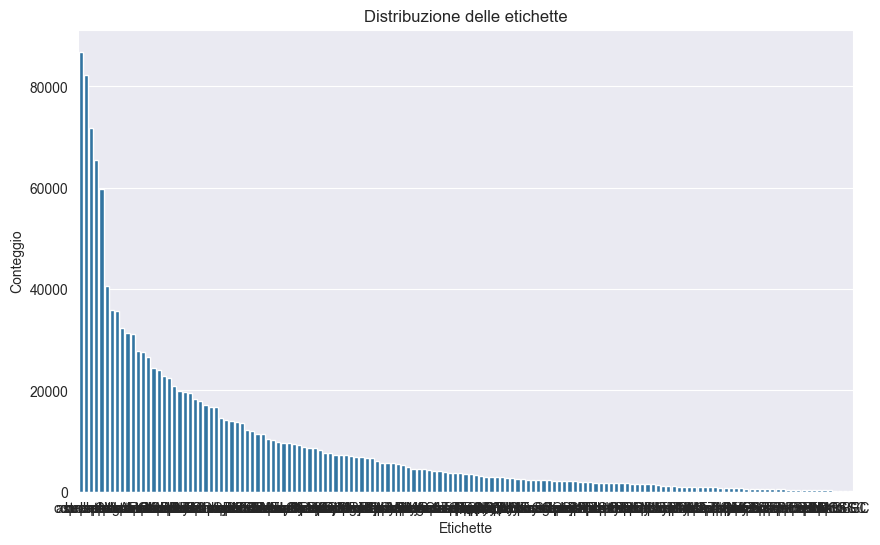

In [18]:
# Controlla la distribuzione delle etichette
label_counts = df['categories'].value_counts()

# Stampa i conteggi
print(label_counts)

# Visualizza la distribuzione
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Distribuzione delle etichette")
plt.xlabel("Etichette")
plt.ylabel("Conteggio")
plt.show()

In [19]:
# Definisci le 5 categorie principali su cui concentrarti
top_5_categories = ['astro-ph', 'hep-ph', 'quant-ph', 'cs.CV', 'hep-th']

# Filtra il dataset per mantenere solo le righe con le categorie principali
df_cleaned = df[df['categories'].isin(top_5_categories)]

df_cleaned.reset_index(drop=True)

df_cleaned.head()

,categories,abstract
0,hep-ph,A fully differential calculation in perturba...
6,astro-ph,We discuss the results from the combined IRA...
10,hep-th,The pure spinor formulation of the ten-dimen...
11,hep-ph,"In this work, we evaluate the lifetimes of t..."
12,astro-ph,Results from spectroscopic observations of t...


categories
astro-ph    86851
hep-ph      82211
quant-ph    71789
cs.CV       65457
hep-th      59671
Name: count, dtype: int64


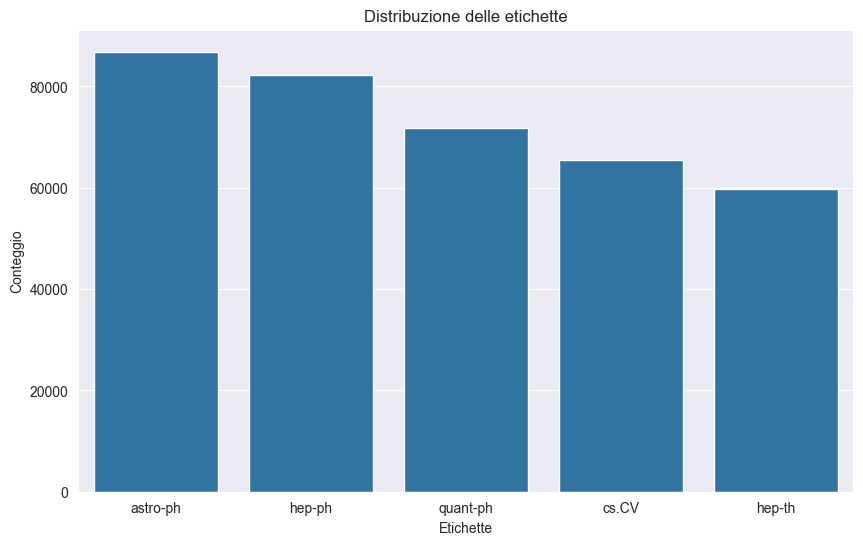

In [20]:
# Controlla la distribuzione delle etichette
label_counts = df_cleaned['categories'].value_counts()

# Stampa i conteggi
print(label_counts)

# Visualizza la distribuzione
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Distribuzione delle etichette")
plt.xlabel("Etichette")
plt.ylabel("Conteggio")
plt.show()

categories
astro-ph    59671
cs.CV       59671
hep-ph      59671
hep-th      59671
quant-ph    59671
Name: count, dtype: int64


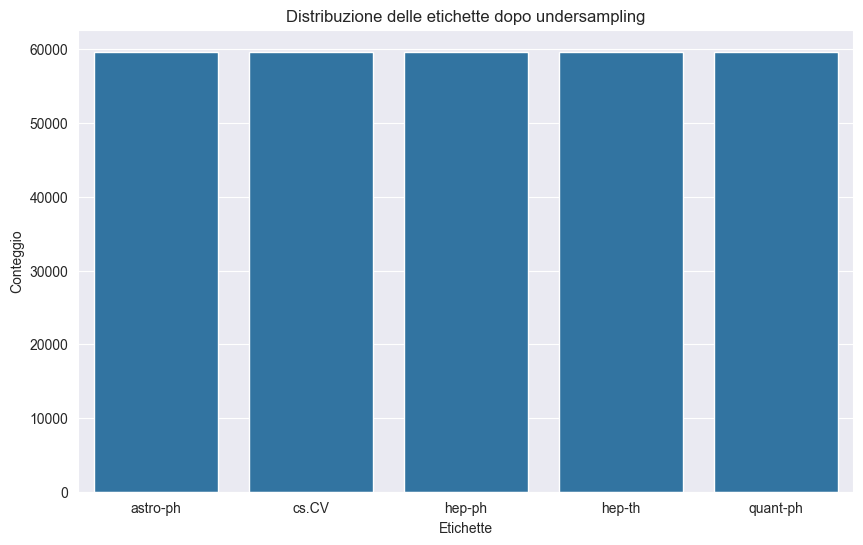

,categories,abstract
1135211,astro-ph,The results of an analysis of the large scal...
1176691,astro-ph,Proper motions and radial velocities of lumi...
1124498,astro-ph,We have imaged five compact high-velocity cl...
1145170,astro-ph,Various scenarios have been proposed to expl...
1109626,astro-ph,We have implemented likelihood testing of th...


In [21]:
# Undersampling: trovare la dimensione della classe minoritaria
min_class_size = label_counts.min()

# Creare un nuovo dataset con undersampling
undersampled_data = df_cleaned.groupby('categories').sample(n=min_class_size, random_state=42)

# Verificare la nuova distribuzione delle etichette
undersampled_label_counts = undersampled_data['categories'].value_counts()

print(undersampled_label_counts)

# Visualizzare la nuova distribuzione delle etichette
plt.figure(figsize=(10, 6))
sns.barplot(x=undersampled_label_counts.index, y=undersampled_label_counts.values)
plt.title("Distribuzione delle etichette dopo undersampling")
plt.xlabel("Etichette")
plt.ylabel("Conteggio")
plt.show()

undersampled_data.head()

In [22]:
def clean_text(text):
    # Rimuove link, caratteri speciali e converte in minuscolo
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)  # Rimuove menzioni e hashtag
    text = re.sub(r"[^a-zA-Z0-9\s]", '', text)  # Mantiene solo lettere e numeri
    text = text.lower()  # Converte in minuscolo
    text = text.strip()  # Rimuove spazi extra
    return text

# Applicare la pulizia
undersampled_data['abstract'] = undersampled_data['abstract'].apply(clean_text)

undersampled_data.head()

,categories,abstract
1135211,astro-ph,the results of an analysis of the large scale ...
1176691,astro-ph,proper motions and radial velocities of lumino...
1124498,astro-ph,we have imaged five compact highvelocity cloud...
1145170,astro-ph,various scenarios have been proposed to explai...
1109626,astro-ph,we have implemented likelihood testing of the ...


# Doc2Vec

In [23]:
# Suddividiamo il dataset in train, validation e test set
train_data, temp_data = train_test_split(undersampled_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Training set: {len(train_data)}, Validation set: {len(val_data)}, Test set: {len(test_data)}")

Training set: 238684, Validation set: 29835, Test set: 29836


#### Trasformazione dei testi in vettori di feature

In [24]:
# Prepara i documenti taggati solo per il training set
tagged_train = [TaggedDocument(words=row['abstract'].split(), tags=[str(index)])
                for index, row in train_data.iterrows()]

In [25]:
# Creazione e addestramento del modello Doc2Vec
model = Doc2Vec(vector_size=50, window=5, min_count=2, workers=4, epochs=20)
model.build_vocab(tagged_train)

# Addestramento con tempo stimato rimanente
print("Inizio dell'addestramento...\n")
start_time = time.time()

for epoch in tqdm(range(model.epochs), desc="Epoche", unit="epoca"):
    model.train(tagged_train, total_examples=model.corpus_count, epochs=1)
    model.alpha -= 0.001  # Diminuiamo il learning rate per stabilizzare l'apprendimento
    model.min_alpha = model.alpha  # Impostiamo il valore minimo

end_time = time.time()
print(f"\nAddestramento completato in {end_time - start_time:.2f} secondi.")

Inizio dell'addestramento...



Epoche: 100%|██████████| 20/20 [02:50<00:00,  8.54s/epoca]


Addestramento completato in 170.75 secondi.


In [26]:
# Inferenza dei vettori per validation e test set
def infer_vectors(df, model):
    return [model.infer_vector(row['abstract'].split()) for _, row in df.iterrows()]

# Generazione dei vettori per training, validation e test set
X_train = infer_vectors(train_data, model)
X_val = infer_vectors(val_data, model)
X_test = infer_vectors(test_data, model)

# Etichette (target) per ciascun set
y_train = train_data['categories']
y_val = val_data['categories']
y_test = test_data['categories']

print("Vettori di feature generati per training, validation e test set.")

Vettori di feature generati per training, validation e test set.


# Naive Bayes Classifier

In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Creazione e addestramento del Naive Bayes Classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Predizione sul validation set
y_val_pred_nb = nb_classifier.predict(X_val)
y_val_proba_nb = nb_classifier.predict_proba(X_val)[:, 1]  # Probabilità per la classe positiva

# Accuracy e Classification Report
print("Naive Bayes Classifier - Validation Set")
print("Accuracy:", accuracy_score(y_val, y_val_pred_nb))
print("Classification Report:\n", classification_report(y_val, y_val_pred_nb))

Naive Bayes Classifier - Validation Set
Accuracy: 0.38337523043405397
Classification Report:
               precision    recall  f1-score   support

    astro-ph       0.64      0.20      0.30      5935
       cs.CV       0.40      0.67      0.50      5995
      hep-ph       0.36      0.13      0.19      5958
      hep-th       0.31      0.67      0.43      6037
    quant-ph       0.47      0.25      0.32      5910

    accuracy                           0.38     29835
   macro avg       0.44      0.38      0.35     29835
weighted avg       0.44      0.38      0.35     29835



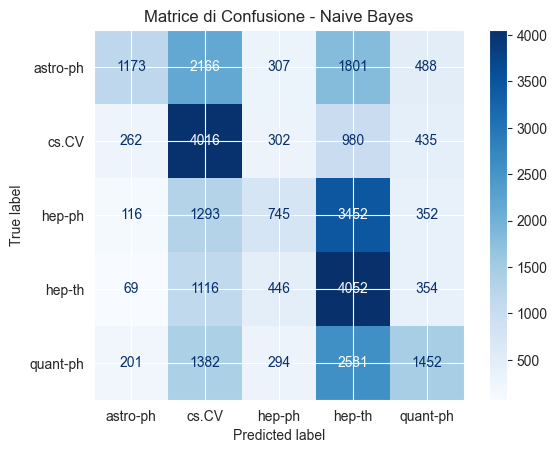

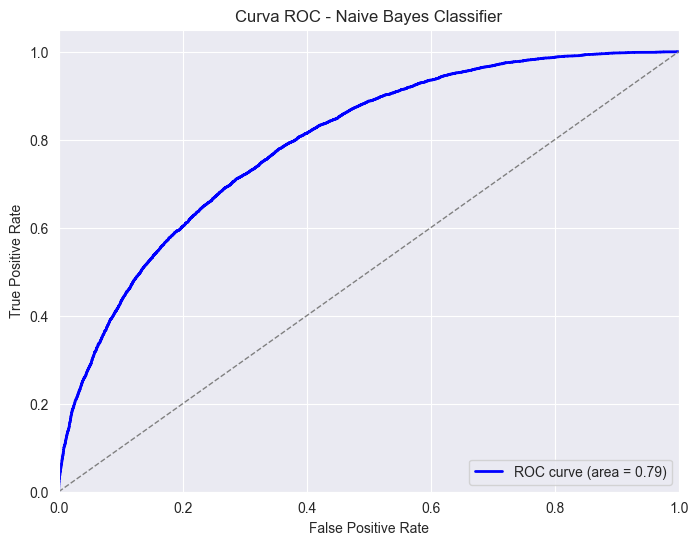

In [28]:
# Matrice di Confusione
cm = confusion_matrix(y_val, y_val_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_classifier.classes_)
disp.plot(cmap="Blues")
plt.title("Matrice di Confusione - Naive Bayes")
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_val, y_val_proba_nb, pos_label=nb_classifier.classes_[1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Naive Bayes Classifier')
plt.legend(loc="lower right")
plt.show()

# Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
lr_classifier = LogisticRegression(max_iter=1000, random_state=42)
lr_classifier.fit(X_train, y_train)

# Predizione
y_val_pred_lr = lr_classifier.predict(X_val)
y_val_proba_lr = lr_classifier.predict_proba(X_val)[:, 1]

# Accuracy e Report
print("Logistic Regression - Validation Set")
print("Accuracy:", accuracy_score(y_val, y_val_pred_lr))
print("Classification Report:\n", classification_report(y_val, y_val_pred_lr))

Logistic Regression - Validation Set
Accuracy: 0.5338025808614044
Classification Report:
               precision    recall  f1-score   support

    astro-ph       0.59      0.50      0.54      5935
       cs.CV       0.62      0.61      0.62      5995
      hep-ph       0.45      0.46      0.45      5958
      hep-th       0.43      0.47      0.45      6037
    quant-ph       0.60      0.63      0.61      5910

    accuracy                           0.53     29835
   macro avg       0.54      0.53      0.53     29835
weighted avg       0.54      0.53      0.53     29835



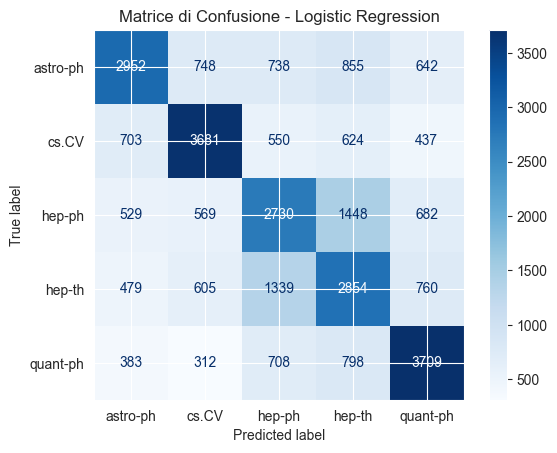

ValueError: multiclass format is not supported

In [24]:
# Matrice di Confusione
cm = confusion_matrix(y_val, y_val_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_classifier.classes_)
disp.plot(cmap="Blues")
plt.title("Matrice di Confusione - Logistic Regression")
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_val, y_val_proba_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

# Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
from time import time

# Monitoraggio del tempo totale
total_start = time()

# Addestramento SVM con stima del tempo
print("Inizio addestramento SVM...")
start_time = time()
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)

# Stima del progresso con stampa periodica
print("Addestramento in corso...")
svm_classifier.fit(X_train, y_train)
end_time = time()
print(f"Addestramento completato in {end_time - start_time:.2f} secondi.")

# Predizione con monitoraggio del tempo
print("Inizio predizione sul validation set...")
pred_start = time()
y_val_pred_svm = svm_classifier.predict(X_val)
y_val_proba_svm = svm_classifier.predict_proba(X_val)
pred_end = time()
print(f"Predizione completata in {pred_end - pred_start:.2f} secondi.")

# Accuracy e Report
print("\nSVM - Validation Set")
print("Accuracy:", accuracy_score(y_val, y_val_pred_svm))
print("Classification Report:\n", classification_report(y_val, y_val_pred_svm))

# Tempo totale
total_end = time()
print(f"Tempo totale di esecuzione: {total_end - total_start:.2f} secondi.")


Inizio addestramento SVM...
Addestramento in corso...


In [ ]:
# Matrice di Confusione
cm = confusion_matrix(y_val, y_val_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_classifier.classes_)
disp.plot(cmap="Blues")
plt.title("Matrice di Confusione - SVM")
plt.show()

# Curva ROC
from sklearn.preprocessing import label_binarize
import numpy as np

# Gestione multi-classe per la curva ROC
y_val_bin = label_binarize(y_val, classes=np.unique(y_val))
n_classes = y_val_bin.shape[1]

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_val_proba_svm[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Classe {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - SVM")
plt.legend(loc="lower right")
plt.show()
